<div class="alert alert-info" role="alert" 
     style="font-size: 1.6em; font-weight: bold; padding: 10px; margin: 10px 0; text-align: center;">
    
    XGBoost model training -- Round 2
</div>

### Import Libraries including `sklearn`, `xgboost`, and `shap`

In [1]:
# Data Wrangling
import glob
import pandas as pd
import numpy as np

# Machine Learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import shap

# Data Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#ignorewarnings
import warnings
warnings.filterwarnings("ignore")

<div class="alert alert-info" role="alert" 
     style="font-size: 1.8em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    Data Preprocessing
</div>

### Load CSV files containing variables -- `glob` and pandas' `read_csv function`

In [2]:
# Define the file pattern to match relevant CSV files
file_pattern = "cmems_training/cmems_mod_glo_phy_my_0.083deg_P1D-m_*.csv"

# Read all matching CSV files into a dictionary
df_dict = {}
for file in glob.glob(file_pattern):
    var_name = file.split("_")[-1].split(".")[0]  # Extract variable name from filename
    df_dict[var_name] = pd.read_csv(file, comment='#')

# Ensure SSH is processed correctly (Dates + renaming 'zos' to 'SSH')
SSH = df_dict.get("SSH")
if SSH is not None:
    SSH['Dates'] = pd.to_datetime(SSH['time'], format='%Y-%m-%dT%H:%M:%S.%fZ', utc=True)
    SSH['Dates'] = SSH['Dates'].dt.strftime('%Y-%m-%d %H:%M')
    SSH['Dates'] = pd.to_datetime(SSH['Dates'])
    SSH = SSH.drop(columns=['time'])
    SSH = SSH.rename(columns={'zos': 'SSH'})  # Rename 'zos' to 'SSH'
    SSH = SSH[['Dates', 'SSH']]  # Keep 'Dates' and SSH variable

# Mapping of expected variables to their corresponding column names in CSVs
data_vars = {
    "SST": "thetao",
    "SSS": "so",
    "Vuo": "uo",
    "Vvo": "vo",
    "MLD": "mlotst"}

# Merge all datasets dynamically
df = SSH.copy() if SSH is not None else pd.DataFrame()

for key, col in data_vars.items():
    dataset_key = "VEL" if key in ["Vuo", "Vvo"] else key  # Ensure velocity data is accessed correctly
    if dataset_key in df_dict:
        df[key] = df_dict[dataset_key][col].values  # Assign values from each dataset

# Print the first few rows to verify the result
print(df.head())

       Dates       SSH        SST        SSS       Vuo       Vvo        MLD
0 1993-01-01 -0.096133  25.840723  36.259041 -0.104373  0.850246  66.225166
1 1993-01-02 -0.106815  25.672995  36.251411 -0.169683  0.775780  69.124428
2 1993-01-03 -0.137028  25.314096  36.233101 -0.120243  0.763573  63.325909
3 1993-01-04 -0.170598  25.159552  36.242256  0.032960  0.979034  50.813320
4 1993-01-05 -0.165105  25.166143  36.240730  0.083010  1.031526  49.897766


<div class="alert alert-info" role="alert" 
     style="font-size: 1.2em; font-weight: bold; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">

    Conspicuously missing from our training thus far has been TIME. 
    We're now going to include Month and Year to see if this improves the accuracy of our SST prediction.
</div>

In [3]:
# Extract months+ years (integers)
df['Month']= df['Dates'].dt.month
df['Year'] = df['Dates'].dt.year

# Display the first 2 rows of the resulting DataFrame
print(df.head(2))
print(':')
print(len(df))

       Dates       SSH        SST        SSS       Vuo       Vvo        MLD  \
0 1993-01-01 -0.096133  25.840723  36.259041 -0.104373  0.850246  66.225166   
1 1993-01-02 -0.106815  25.672995  36.251411 -0.169683  0.775780  69.124428   

   Month  Year  
0      1  1993  
1      1  1993  
:
10408


### Set the `predictor` and `target` variables (X, y)

In [4]:
predictors = ['Month', 'Year', 'SSH', 'SSS', 'Vuo', 'Vvo', 'MLD'] # Predictor vars
X = df[predictors].values 
y = df['SST'].values      # Target variable
# Needs to be (n,n)(n,)
print(X.shape, y.shape)

(10408, 7) (10408,)


### Split the data into two sets: `training` (80%) and `test` (20%)

In [5]:
# Split your dataset so 20% is set aside for testing (0.2) 
# Set random_state to ensure yr train-test split is always the same (for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the 80% training: 20% testing split
print("Trainin set size:", X_train.shape[0])
print("Testing set size:",  X_test.shape[0])

Trainin set size: 8326
Testing set size: 2082


<div class="alert alert-info" role="alert" 
     style="font-size: 1.5em; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    
    Hyperparameter Tuning
</div>

In [6]:
# Define a parameter grid (dictionary) with lists of possible values for each hyperparameter:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],       # Step size shrinkage used to prevent overfitting
    'max_depth': [3, 5, 7],                        # Maximum depth of a tree, controlling model complexity
    'min_child_weight': [1, 3, 5],                 # Minimum sum of instance weight (hessian) needed in a child
    'subsample': [0.7, 0.8, 0.9, 1.0],             # Fraction of samples to use for each tree
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],      # Fraction of features to consider for each tree
    'n_estimators': [100, 200, 300],               # Number of trees (boosting rounds) to build
    'gamma': [0, 0.1, 0.5]                         # Minimum loss reduction required to make a split
}

# Initialise XGBoost regressor model with squared error objective.
xgb_reg = xgb.XGBRegressor(objective = 'reg:squarederror', random_state = 42)

# Set up RandomizedSearchCV with the following parameters:
random_search = RandomizedSearchCV(
    estimator = xgb_reg,                          # The base model to optimize (our XGBoost regressor)
    param_distributions=param_grid,               # Dictionary with parameters to sample from (our grid)
    n_iter = 100,                                 # Number of random parameter combinations to try (reduces total fits)
    scoring='r2',                                 # Metric to evaluate performance (R² in this case)
    cv = 5,                                       # Number of cross-validation folds (5-fold cross-validation)
    verbose= 1,                                   # Verbosity level to print progress messages during the search
    n_jobs =-1,                                   # Use all available CPU cores to parallelize the search
    random_state = 42                             # Random seed for reproducibility of the random sampling
)

# Fit the randomised search on the training data:
random_search.fit(X_train, y_train)

# Print best hyperparameters and cross-validation (CV) scores
print("Best parameters:", random_search.best_params_)
print()
print("Best XGBoost CV R²: {:.2f}".format(random_search.best_score_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}

Best XGBoost CV R²: 0.96


### Yes! From `R²`= 0.72 to `R²`= 0.96. We can now save this 'even better' model using `save_model()`.

In [7]:
# Save the model to a JSON file
random_search.best_estimator_.save_model("xgb_sst_model2.json")

In [8]:
# Using SHAP to explain our model predictions with XGBoost
explainer = shap.TreeExplainer(random_search.best_estimator_)  # Use best_estimator_ from random_search
shap_vals = explainer.shap_values(X_test)                      # Compute SHAP values for your test data

# Compute the mean absolute SHAP values for each feature
# This provides a robust measure of feature importance
shap_importance = np.abs(shap_vals).mean(axis = 0)

# Create df of the features and their importance (SHAP)
shap_df = pd.DataFrame({
    "Variable": predictors,
    "Mean Absolute SHAP": shap_importance})

# Sort shap_df so the most important features (variables) are at the top:
shap_df.sort_values(by = "Mean Absolute SHAP", ascending = False, inplace = True)
print(shap_df)

  Variable  Mean Absolute SHAP
0    Month            1.484284
2      SSH            0.338693
6      MLD            0.138221
1     Year            0.127036
5      Vvo            0.097673
3      SSS            0.085937
4      Vuo            0.027870


### Clearly, `Month` is an incredibly important feature, and `Year` is moderately important for predicting SST.

<div class="alert alert-info" role="alert" 
     style="font-size: 1.6em; font-weight: bold; padding: 10px; margin: 10px 0; text-align: center;">

    XGBoost model deployment -- Round 2

</div>

In [9]:
# Define the file pattern to match the new CSV files
file_pattern = "cmems_testing_/cmems_mod_glo_phy-*_0.083deg_P1D-m.csv"

# Read all matching CSV files into a dictionary
df_dict = {}
for file in glob.glob(file_pattern):
    # Extract variable name: get text after 'cmems_mod_glo_phy-' and before the first underscore
    var_name = file.split("cmems_mod_glo_phy-")[-1].split("_")[0]
    df_dict[var_name.upper()] = pd.read_csv(file, comment='#')  # Use upper-case keys for consistency

# Process SSH separately (for Dates and renaming 'zos' to 'SSH')
# Assuming the SSH file is named like: cmems_mod_glo_phy-ssh_0.083deg_P1D-m.csv
SSH = df_dict.get("SSH")
if SSH is not None:
    SSH['Dates'] = pd.to_datetime(SSH['time'], format='%Y-%m-%dT%H:%M:%S.%fZ', utc=True)
    SSH['Dates'] = SSH['Dates'].dt.strftime('%Y-%m-%d %H:%M')
    SSH['Dates'] = pd.to_datetime(SSH['Dates'])
    # Extract months+ years (integers)
    SSH['Month'] = SSH['Dates'].dt.month
    SSH['Year']  = SSH['Dates'].dt.year
    # Tidy up
    SSH = SSH.drop(columns=['time'])
    SSH = SSH.rename(columns={'zos': 'SSH'})    # Rename 'zos' to 'SSH'
    SSH = SSH[['Dates', 'Month', 'Year', 'SSH']]  # Keep selected vars

# Mapping of expected variables to their corresponding column names in CSVs.
# Use upper-case keys to match our dictionary keys.
data_vars = {
    "SST": "thetao",
    "SSS": "so",
    "Vuo": "uo",
    "Vvo": "vo",
    "MLD": "mlotst"}

# Start with the SSH DataFrame if available; otherwise, create an empty one.
new_df = SSH.copy() if SSH is not None else pd.DataFrame()

# Loop through each expected variable, and add its values if available
for key, col in data_vars.items():
    # For velocities, assume the file is named with 'VEL' instead of the variable name
    dataset_key = "VEL" if key in ["Vuo", "Vvo"] else key
    # Here, we assume that in the new files the key is simply the variable name (upper-case)
    if dataset_key in df_dict:
        new_df[key] = df_dict[dataset_key][col].values  # Assign the column values

# Print the first few rows to verify the result
print(new_df.head())

       Dates  Month  Year       SSH        SST        SSS       Vuo       Vvo  \
0 2022-06-01      6  2022 -0.157100  28.285259  36.208824  0.214361  2.172305   
1 2022-06-02      6  2022 -0.157860  28.619026  36.249100  0.250755  2.062931   
2 2022-06-03      6  2022 -0.120291  28.477537  36.231472  0.390796  1.769881   
3 2022-06-04      6  2022 -0.103189  28.041946  36.217098  0.292578  1.761578   
4 2022-06-05      6  2022 -0.052188  28.271646  36.118107  0.315040  1.895313   

         MLD  
0  11.826362  
1  15.236107  
2  12.486409  
3  11.842813  
4  16.884359  


In [10]:
predictors = ['Month', 'Year', 'SSH', 'SSS', 'Vuo', 'Vvo', 'MLD'] # Predictor vars
X_new = new_df[predictors].values     # Features
y_new = new_df['SST'].values          # True SST values
# Check reshaped data (n,n)(n,)
print(X_new.shape, y_new.shape)

(1028, 7) (1028,)


<div class="alert alert-info" role="alert" 
     style="font-size: 1.5em; padding: 15px; margin: 10px 0; text-align: center; background-color: #d9edf7; border-color: #bce8f1; color: #31708f; border-radius: 8px;">
    
    Even-Better Model
</div>

In [11]:
sst_model = xgb.XGBRegressor()               # Create new XGBoost regressor
sst_model.load_model("xgb_sst_model2.json")  # Load the model saved to disk

In [12]:
# Saved XGBoost model: predict 'new' SST
sst_pred = sst_model.predict(X_new)

# Evaluate model performance: 
# R², MSE, RMSE for new data
r2  = r2_score(y_new, sst_pred)
mse = mean_squared_error(y_new, sst_pred, squared = False)
rmse= np.sqrt(mse)

# Print output
print(f"XGBoost Deployment R²  : {r2:.2f}" )
print(f"XGBoost Deployment MSE : {mse:.2f}")
print(f"XGBoost Deployment RMSE: {rmse:.2f}")

XGBoost Deployment R²  : 0.79
XGBoost Deployment MSE : 1.00
XGBoost Deployment RMSE: 1.00


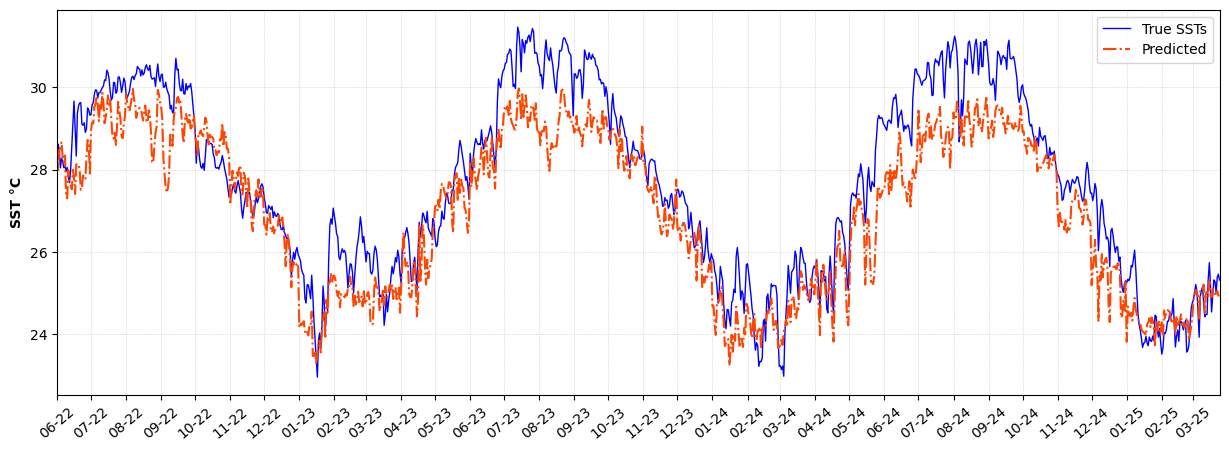

In [13]:
# Create figure
fig1, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot True and Predicted SSTs
ax.plot(new_df['Dates'], new_df['SST'], linestyle = '-', c = 'blue', linewidth = 1.0, label = 'True SSTs')
ax.plot(new_df['Dates'], sst_pred,linestyle = '-.', c = 'orangered', linewidth = 1.5, label = 'Predicted')

# Formatting
ax.grid(True, color = 'silver', linestyle = ':', linewidth = 0.5)
ax.set_xlim([np.nanmin(new_df['Dates']), np.nanmax(new_df['Dates'])])
ax.set_ylabel('SST °C', fontsize = 10, weight = 'bold')
ax.legend();

# Set the x-axis major locator to every 3 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 1))
# Format the x-axis ticks as 'mm-yy'
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
# Rotate tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation = 40, ha = 'center')

plt.show()

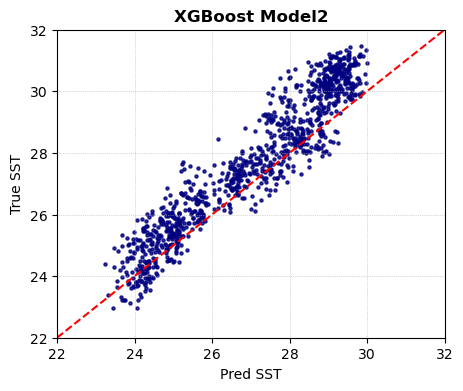

In [14]:
# Create Scatterplot
fig2, ax = plt.subplots(1, 1, figsize=(5, 4))
# Plot True and Predicted SSTs
ax.scatter(sst_pred, new_df['SST'], color = 'navy', alpha = 0.8, marker = 'o', s = 5)
# Set axes limits
ax.set_xlim(22, 32)
ax.set_ylim(22, 32)
# Plot a 1:1 line
ax.plot([22, 32], [22, 32], color = 'red', linestyle = '--', linewidth = 1.5)
# Formatting 
ax.set_xlabel('Pred SST')                           
ax.set_ylabel('True SST')                           
ax.set_title('XGBoost Model2',weight = 'bold')    
ax.grid(True, linestyle = ':', linewidth = 0.5) 